## Modeling on Gram
- 지금까지 공개된 FE 노하우를 총정리한 커널: [CIS Fraud Detection(Visualize+Feature Engineering)](https://www.kaggle.com/ysjf13/cis-fraud-detection-visualize-feature-engineering)
- 결과: 0.9476

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import gc, os, pickle

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk("../input/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/df_id.pkl
../input/df_pca.pkl
../input/df_test.pkl
../input/df_train.pkl
../input/df_trans.pkl
../input/sample_submission.csv
../input/second_test.pkl
../input/second_train.pkl
../input/test.pkl
../input/test_0823.pkl
../input/test_identity.csv
../input/test_transaction.csv
../input/train_0823.pkl
../input/train_identity.csv
../input/train_transaction.csv


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
%%time
folder_path = '../input/'
print('Loading data...')

train_identity = pd.read_csv(f'{folder_path}train_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_identity!')

train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_transaction!')

test_identity = pd.read_csv(f'{folder_path}test_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_identity!')

test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_transaction!')

sub = pd.read_csv(f'{folder_path}sample_submission.csv')
print('\tSuccessfully loaded sample_submission!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded train_transaction!
	Successfully loaded test_identity!
	Successfully loaded test_transaction!
	Successfully loaded sample_submission!
Data was successfully loaded!

Wall time: 1min 4s


In [4]:
print('Merging data...')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print('Data was successfully merged!\n')

del train_identity, train_transaction, test_identity, test_transaction

print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

gc.collect()

Merging data...
Data was successfully merged!

Train dataset has 590540 rows and 433 columns.
Test dataset has 506691 rows and 432 columns.


60

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1975.37 MB
Memory usage after optimization is: 547.82 MB
Decreased by 72.3%
Memory usage of dataframe is 1693.87 MB
Memory usage after optimization is: 480.15 MB
Decreased by 71.7%


In [6]:
%%time
train.to_pickle("../input/third_train.pkl")
test.to_pickle("../input/third_test.pkl")

Wall time: 6.72 s


In [7]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

for df in [train, test]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column. 이건 왜 하는지 모르겠지만 일단 해 놓기
    df['D9'] = np.where(df['D9'].isna(),0,1)

In [8]:
# 칼럼 수 확인 -> 440개
print(train.shape)
print(test.shape)

(590540, 440)
(506691, 439)


In [9]:
# card 컬럼들 이용한 uid 생성
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)
    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)
    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    return data

In [10]:
train = addNewFeatures(train)
test = addNewFeatures(test)

In [11]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        # i_cols 그룹별 평균값을 가지는 칼럼 생성. 딱히 칼럼 제거하진 않는 듯
        new_col_name = col + '_TransactionAmt_' + agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [12]:
%%time
# df.replace -> 여기서 이 코드는 무슨 의미인지??
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

Wall time: 14.6 s


In [13]:
# 트리기반 모델 -> 여기서 log 처리한다고 달라질 것 같진 않음. 일단 해보기
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

### 주요 FE 1. email mapping

In [15]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### 주요 FE 2. Browser mapping

In [16]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train = setBrowser(train)
test = setBrowser(test)

### 주요 FE 3. Device mapping

In [17]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train = setDevice(train)
test = setDevice(test)

In [18]:
# Frequency Encoding?
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']

for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [20]:
train.columns[train.columns.str.contains('Transaction')]

Index(['TransactionDT', 'TransactionAmt', 'card1_TransactionAmt_mean',
       'card1_TransactionAmt_std', 'card2_TransactionAmt_mean',
       'card2_TransactionAmt_std', 'card3_TransactionAmt_mean',
       'card3_TransactionAmt_std', 'card5_TransactionAmt_mean',
       'card5_TransactionAmt_std', 'uid_TransactionAmt_mean',
       'uid_TransactionAmt_std', 'uid2_TransactionAmt_mean',
       'uid2_TransactionAmt_std', 'uid3_TransactionAmt_mean',
       'uid3_TransactionAmt_std'],
      dtype='object')

In [21]:
# noisy columns 제거? 이 부분을 일단 안함!! -> 안한거 맞나?(9/25)
noisy_cols = [#'TransactionID',
    'TransactionDT', # Not target in features
    'uid','uid2','uid3',                                 
    'DT','DT_M','DT_W','DT_D',       
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
    'D1', 'D2', 'D9',
]

noisy_cat_cols = list(train[noisy_cols].select_dtypes(include=['object']).columns) 
noisy_num_cold = list(train[noisy_cols].select_dtypes(exclude=['object']).columns)

In [22]:
cat_attr = list(train.select_dtypes(include=['object']).columns)
num_attr = list(train.select_dtypes(exclude=['object']).columns)
num_attr.remove('isFraud')

for col in noisy_cat_cols:
    if col in cat_attr:
        print("Deleting " + col)
        cat_attr.remove(col)
for col in noisy_num_cold:
    if col in num_attr:
        print("Deleting " + col)
        num_attr.remove(col)

Deleting uid
Deleting uid2
Deleting uid3
Deleting id_30
Deleting id_31
Deleting id_33
Deleting TransactionDT
Deleting DT
Deleting DT_M
Deleting DT_W
Deleting DT_D
Deleting DT_hour
Deleting DT_day_week
Deleting DT_day
Deleting DT_D_total
Deleting DT_W_total
Deleting DT_M_total
Deleting D1
Deleting D2
Deleting D9


In [23]:
%%time
# object data -> Label Encoding(모델링 위해)
# 그냥 팁: pandas에서 object보다 category 형 변수가 계산 빠름(변성윤님 블로그)?
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

Wall time: 1min 17s


In [24]:
from sklearn.model_selection import KFold
import lightgbm as lgb

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [ ]:
%%time
# 여기서 TransactionDT 빼는 이유는 뭐지?? -> dtype 안 맞기 때문??
# 일단 DT는 맞는 dtype이 아니라서 제거
# 특이하게 여기서 시간이 몇 분 걸렸음.
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'DT'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

X_test = test.drop(['TransactionDT', 'DT'], axis=1)

del train, test
gc.collect()

In [27]:
print(X.shape)
print(X_test.shape)

(590540, 506)
(506691, 506)


In [28]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.961565	valid_1's auc: 0.892356
[400]	training's auc: 0.981396	valid_1's auc: 0.905383
[600]	training's auc: 0.991677	valid_1's auc: 0.914151
[800]	training's auc: 0.99651	valid_1's auc: 0.91954
[1000]	training's auc: 0.998625	valid_1's auc: 0.923157
[1200]	training's auc: 0.999484	valid_1's auc: 0.924787
[1400]	training's auc: 0.99981	valid_1's auc: 0.926144
[1600]	training's auc: 0.999931	valid_1's auc: 0.926776
[1800]	training's auc: 0.999978	valid_1's auc: 0.927018
[2000]	training's auc: 0.999994	valid_1's auc: 0.927309
[2200]	training's auc: 0.999998	valid_1's auc: 0.927509
[2400]	training's auc: 1	valid_1's auc: 0.927608
[2600]	training's auc: 1	valid_1's auc: 0.927528
[2800]	training's auc: 1	valid_1's auc: 0.927523
Early stopping, best iteration is:
[2407]	training's auc: 1	valid_1's auc: 0.927663
Fold 1 | AUC: 0.9276628290296187
Training until validation scores don't improve for 500 rounds.
[

In [29]:
# 근데 위에서 제거하려고 했던(list) 칼럼들 모두 제거하진 않았음(drop)
sub['isFraud'] = y_preds
sub.to_csv("0917_submission.csv", index=False)

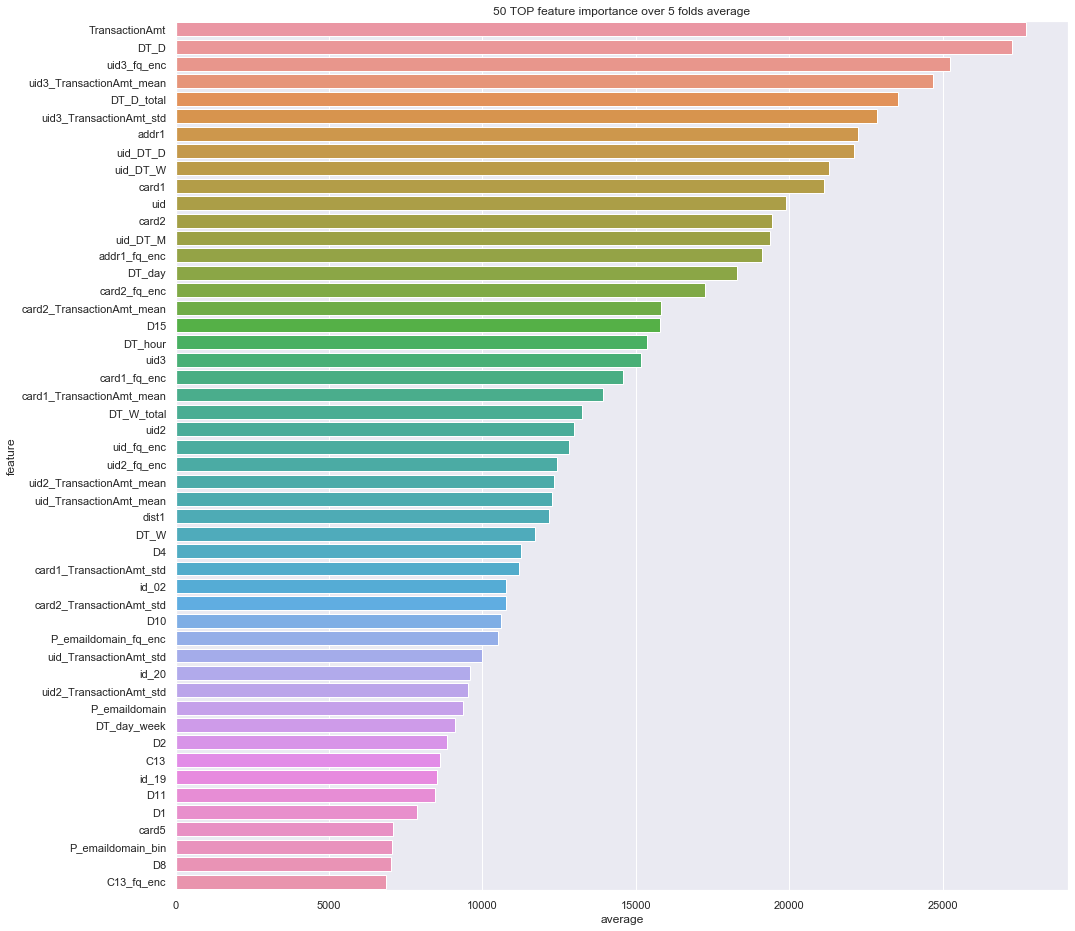

In [30]:
# Feature importance 확인
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances_new.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));